This notebook includes functions for plotting the figures reported in the paper.

In [1]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [2]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [3]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [4]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

## Format violin plot

In [5]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

# Setting global variables 

In [6]:
!pwd

/geode2/home/u015/baotruon/BigRed200/simsom/sm_nov25/all_plots


In [7]:
# Directory containing experiment results
RES_DIR = "/N/project/simsom/simsom_v3/nov25/zl2_11212023/results"

# Directory to save figures
PLOT_DIR = "figures_zl2_11212023"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [8]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Baseline results

In [9]:
folders = ["baseline"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.8937645687397395]
values [0.9020346784367591]
values [0.9031736892342388]
values [0.8939557194741643]
values [0.9047042200311153]
Overall quality when there is no bots: 0.9


# Shuffle 
Effects of network structure on Quality

In [10]:
# SHUFFLE
data = read_data(RES_DIR, ["shuffle_5runs"], keep_file_name=True)

# refer shuffling strategies from file names
data["shuffle"] = data["file_name"].apply(lambda x: x.split("_shuffle__")[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.695056,0.650651,0.650794,0.666220,0.665480,community_shuffle__None3.json,community
1,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.597301,0.605905,0.606476,0.611764,0.609267,hub_shuffle__None3.json,hub
2,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.666599,0.672192,0.656545,0.674922,0.663028,all_shuffle__None3.json,all
3,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.860680,0.855332,0.851385,0.864560,0.871544,all_shuffle__None2.json,all
4,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.823818,0.851867,0.866032,0.837684,0.855928,hub_shuffle__None2.json,hub
5,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.877620,0.866616,0.854728,0.871810,0.855117,community_shuffle__None2.json,community


In [11]:
# NO SHUFFLE
data = read_data(RES_DIR, ["vary_thetaphi_5runs"])
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index

noshuffle = data[(data.theta == 1) & (data.phi == 0)]
noshuffle["shuffle"] = "None"

In [12]:
noshuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,shuffle
54,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.848758,0.840448,0.84842,0.851052,0.850915,None


In [13]:
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.695056,0.650651,0.650794,0.666220,0.665480,community_shuffle__None3.json,community
1,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.597301,0.605905,0.606476,0.611764,0.609267,hub_shuffle__None3.json,hub
2,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.666599,0.672192,0.656545,0.674922,0.663028,all_shuffle__None3.json,all
3,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.860680,0.855332,0.851385,0.864560,0.871544,all_shuffle__None2.json,all
4,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.823818,0.851867,0.866032,0.837684,0.855928,hub_shuffle__None2.json,hub
5,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.877620,0.866616,0.854728,0.871810,0.855117,community_shuffle__None2.json,community


In [14]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

In [15]:
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_3,quality_4,shuffle,file_name,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,id
0,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.848758,...,0.851052,0.850915,None,NaN,0.943561,0.934322,0.943185,0.946111,0.945959,0
1,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.695056,...,0.666220,0.665480,community,community_shuffle__None3.json,0.772691,0.723326,0.723485,0.740634,0.739811,1
2,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.597301,...,0.611764,0.609267,hub,hub_shuffle__None3.json,0.664017,0.673582,0.674217,0.680096,0.677319,2
3,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.666599,...,0.674922,0.663028,all,all_shuffle__None3.json,0.741055,0.747273,0.729879,0.750307,0.737085,3
4,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.860680,...,0.864560,0.871544,all,all_shuffle__None2.json,0.956814,0.950869,0.946481,0.961128,0.968892,4
5,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.823818,...,0.837684,0.855928,hub,hub_shuffle__None2.json,0.915835,0.947017,0.962765,0.931250,0.951532,5
6,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.877620,...,0.871810,0.855117,community,community_shuffle__None2.json,0.975646,0.963413,0.950197,0.969187,0.950630,6


In [16]:
results

,id,run_no,targeting_criterion,rho,epsilon,beta,mu,quality_1,gamma,quality_0,graph_gml,theta,quality_4,phi,quality_3,shuffle,file_name,quality_2,relative_quality_
0,0,0,none,0.8,0.0001,0.05,0.5,0.840448,0.01,0.848758,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.850915,0.0,0.851052,None,NaN,0.848420,0.943561
1,1,0,none,0.8,0.0001,0.05,0.5,0.650651,0.10,0.695056,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.665480,0.0,0.666220,community,community_shuffle__None3.json,0.650794,0.772691
2,2,0,none,0.8,0.0001,0.05,0.5,0.605905,0.10,0.597301,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.609267,0.0,0.611764,hub,hub_shuffle__None3.json,0.606476,0.664017
3,3,0,none,0.8,0.0001,0.05,0.5,0.672192,0.10,0.666599,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.663028,0.0,0.674922,all,all_shuffle__None3.json,0.656545,0.741055
4,4,0,none,0.8,0.0001,0.05,0.5,0.855332,0.01,0.860680,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.871544,0.0,0.864560,all,all_shuffle__None2.json,0.851385,0.956814
5,5,0,none,0.8,0.0001,0.05,0.5,0.851867,0.01,0.823818,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.855928,0.0,0.837684,hub,hub_shuffle__None2.json,0.866032,0.915835
6,6,0,none,0.8,0.0001,0.05,0.5,0.866616,0.01,0.877620,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.855117,0.0,0.871810,community,community_shuffle__None2.json,0.854728,0.975646
7,0,1,none,0.8,0.0001,0.05,0.5,0.840448,0.01,0.848758,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.850915,0.0,0.851052,None,NaN,0.848420,0.934322
8,1,1,none,0.8,0.0001,0.05,0.5,0.650651,0.10,0.695056,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.665480,0.0,0.666220,community,community_shuffle__None3.json,0.650794,0.723326
9,2,1,none,0.8,0.0001,0.05,0.5,0.605905,0.10,0.597301,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.609267,0.0,0.611764,hub,hub_shuffle__None3.json,0.606476,0.673582


Plot data for default values $\gamma=0.01$

In [17]:
plot_data = results[(results.gamma == 0.01) & (results.targeting_criterion == "none")]
plot_data.head()

,id,run_no,targeting_criterion,rho,epsilon,beta,mu,quality_1,gamma,quality_0,graph_gml,theta,quality_4,phi,quality_3,shuffle,file_name,quality_2,relative_quality_
0,0,0,none,0.8,0.0001,0.05,0.5,0.840448,0.01,0.848758,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.850915,0.0,0.851052,None,NaN,0.848420,0.943561
4,4,0,none,0.8,0.0001,0.05,0.5,0.855332,0.01,0.860680,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.871544,0.0,0.864560,all,all_shuffle__None2.json,0.851385,0.956814
5,5,0,none,0.8,0.0001,0.05,0.5,0.851867,0.01,0.823818,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.855928,0.0,0.837684,hub,hub_shuffle__None2.json,0.866032,0.915835
6,6,0,none,0.8,0.0001,0.05,0.5,0.866616,0.01,0.877620,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.855117,0.0,0.871810,community,community_shuffle__None2.json,0.854728,0.975646
7,0,1,none,0.8,0.0001,0.05,0.5,0.840448,0.01,0.848758,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.850915,0.0,0.851052,None,NaN,0.848420,0.934322


In [18]:
# !pip install statannotations

In [19]:
plot_data

,id,run_no,targeting_criterion,rho,epsilon,beta,mu,quality_1,gamma,quality_0,graph_gml,theta,quality_4,phi,quality_3,shuffle,file_name,quality_2,relative_quality_
0,0,0,none,0.8,0.0001,0.05,0.5,0.840448,0.01,0.848758,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.850915,0.0,0.851052,None,NaN,0.848420,0.943561
4,4,0,none,0.8,0.0001,0.05,0.5,0.855332,0.01,0.860680,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.871544,0.0,0.864560,all,all_shuffle__None2.json,0.851385,0.956814
5,5,0,none,0.8,0.0001,0.05,0.5,0.851867,0.01,0.823818,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.855928,0.0,0.837684,hub,hub_shuffle__None2.json,0.866032,0.915835
6,6,0,none,0.8,0.0001,0.05,0.5,0.866616,0.01,0.877620,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.855117,0.0,0.871810,community,community_shuffle__None2.json,0.854728,0.975646
7,0,1,none,0.8,0.0001,0.05,0.5,0.840448,0.01,0.848758,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.850915,0.0,0.851052,None,NaN,0.848420,0.934322
11,4,1,none,0.8,0.0001,0.05,0.5,0.855332,0.01,0.860680,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.871544,0.0,0.864560,all,all_shuffle__None2.json,0.851385,0.950869
12,5,1,none,0.8,0.0001,0.05,0.5,0.851867,0.01,0.823818,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.855928,0.0,0.837684,hub,hub_shuffle__None2.json,0.866032,0.947017
13,6,1,none,0.8,0.0001,0.05,0.5,0.866616,0.01,0.877620,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.855117,0.0,0.871810,community,community_shuffle__None2.json,0.854728,0.963413
14,0,2,none,0.8,0.0001,0.05,0.5,0.840448,0.01,0.848758,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.850915,0.0,0.851052,None,NaN,0.848420,0.943185
18,4,2,none,0.8,0.0001,0.05,0.5,0.855332,0.01,0.860680,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,0.871544,0.0,0.864560,all,all_shuffle__None2.json,0.851385,0.946481


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:1.517e-02 t=3.498e+00
hubs vs. communities: Welch's t-test independent samples, P_val:7.704e-02 t=-2.091e+00
random vs. hubs: Welch's t-test independent samples, P_val:1.489e-01 t=1.667e+00
random vs. hubs+communities: Welch's t-test independent samples, P_val:1.819e-02 t=3.177e+00


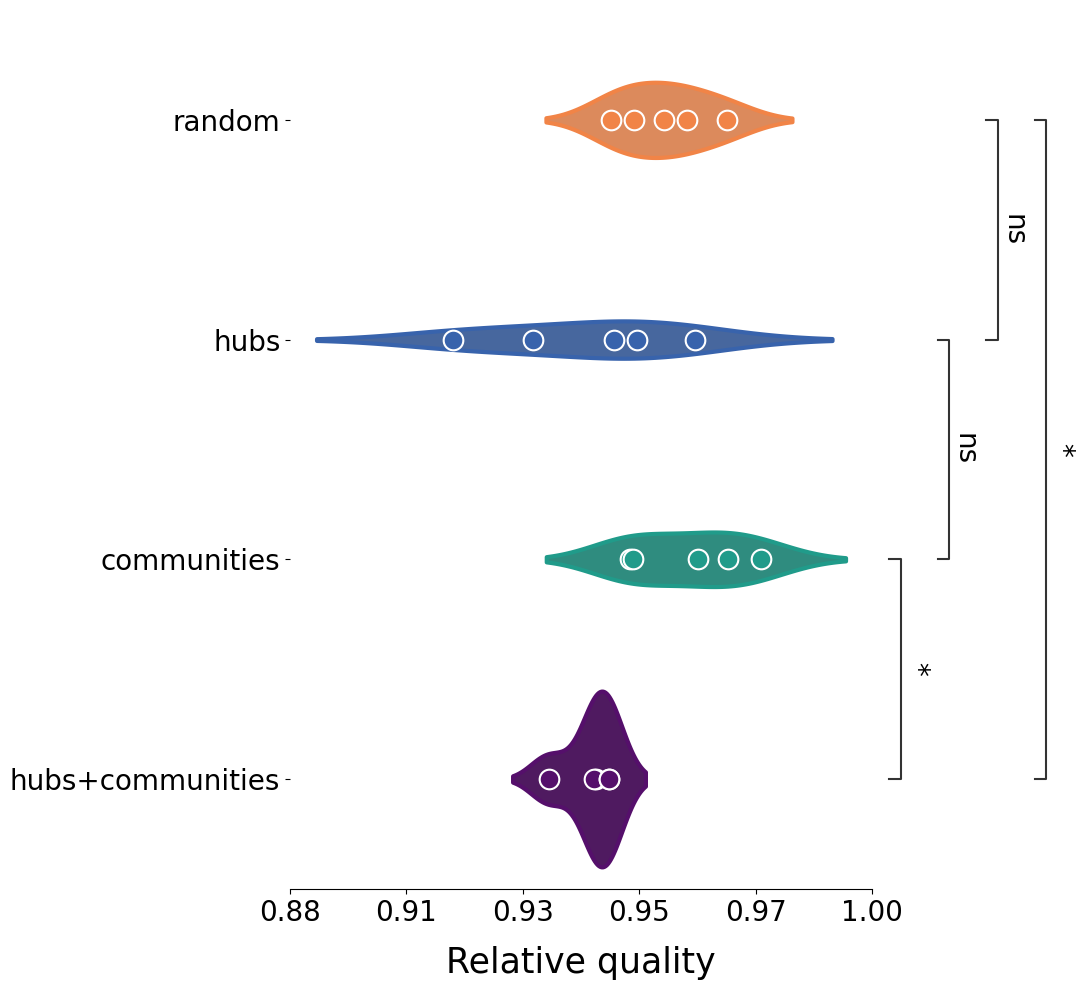

In [20]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "shuffle")
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order = ["random", "hubs", "communities", "hubs+communities"]

# Rename shuffles
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "random" if x == "all" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "hubs+communities" if x == "None" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(lambda x: "hubs" if x == "hub" else x)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "communities" if x == "community" else x
)

violin = sns.violinplot(
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    order=order,
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

pairs = [
    ("hubs+communities", "communities"),
    ("hubs+communities", "random"),
    ("hubs", "communities"),
    ("hubs", "random"),
]
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    # comparisons_correction="bonferroni"
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# violin.set(yticklabels=[])
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=25, labelpad=14)
patch_violinplot(ax, palette=BLUEPALETTE, n=4)
point_violinplot(ax, palette=BLUEPALETTE, n=4)
sns.despine(top=True, left=True, bottom=False)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Alpha

In [21]:
folders = ["vary_alpha"]
TARGET_PARAMS.append("alpha")

data = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
alphadata = pivot_results(data, col_name_prefix="quality")
alphadata = alphadata.sort_values(by="alpha")
alphadata.head()

,id,run_no,targeting_criterion,relative_quality_1,rho,epsilon,relative_quality_4,beta,relative_quality_0,mu,gamma,graph_gml,theta,alpha,phi,relative_quality_3,relative_quality_2,quality_
13,5,1,none,0.999906,0.8,0.0001,1.02011,0,1.008362,0.5,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,1,0,0.995434,0.998976,0.899442
5,5,0,none,0.999906,0.8,0.0001,1.02011,0,1.008362,0.5,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,1,0,0.995434,0.998976,0.907049
21,5,2,none,0.999906,0.8,0.0001,1.02011,0,1.008362,0.5,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,1,0,0.995434,0.998976,0.898606
37,5,4,none,0.999906,0.8,0.0001,1.02011,0,1.008362,0.5,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,1,0,0.995434,0.998976,0.917617
29,5,3,none,0.999906,0.8,0.0001,1.02011,0,1.008362,0.5,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,1,0,0.995434,0.998976,0.895419


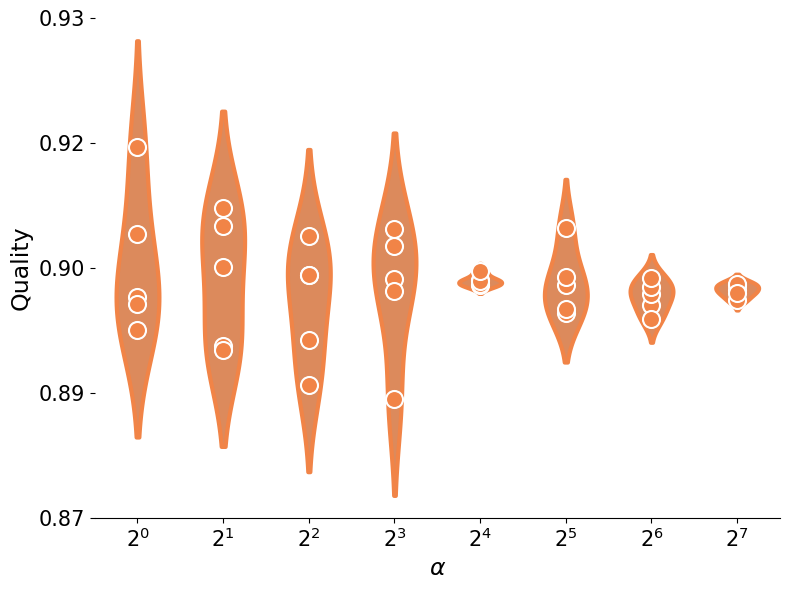

In [22]:
fpath = os.path.join(PLOT_DIR, "alpha")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=alphadata,
    x="alpha",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)

# Formatting
ticks = range(len(alphadata.alpha.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f"$2^{i}$" for i in ticks])

violin.set_xlabel(f"$\\alpha$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)

sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Mu

In [23]:
# Read data
data = read_data(RES_DIR, ["vary_mu"])
data = reindex_cols(data, col_name_prefix="quality")

mudata = pivot_results(data, col_name_prefix="quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

,id,run_no,targeting_criterion,rho,epsilon,beta,mu,gamma,graph_gml,theta,alpha,phi,quality_
3,3,0,none,0.8,0.0001,0,0.1,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,15,0,0.889954
8,3,1,none,0.8,0.0001,0,0.1,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,15,0,0.887763
18,3,3,none,0.8,0.0001,0,0.1,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,15,0,0.900193
23,3,4,none,0.8,0.0001,0,0.1,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,15,0,0.912011
13,3,2,none,0.8,0.0001,0,0.1,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,15,0,0.908828


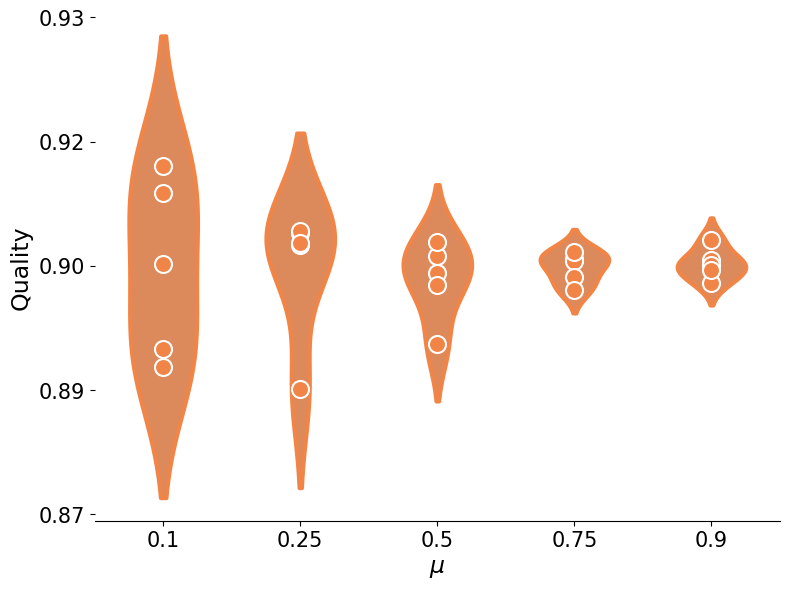

In [24]:
fpath = os.path.join(PLOT_DIR, "mu")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=mudata,
    x="mu",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Bot params

## Read data 
Data is a subset of joint effect experiments

### Thetaphi

In [25]:
data = read_data(
    RES_DIR, folders=["vary_thetaphi_5runs"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
# thetaphi

### Phigamma

In [26]:
data = read_data(
    RES_DIR, folders=["vary_phigamma"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
# phigamma

### Thetagamma

In [27]:
data = read_data(RES_DIR, folders=["vary_thetagamma_5runs"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

In [28]:
thetagamma

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,alpha
0,4,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.894697,0.889803,0.898174,0.895627,0.888135,15
1,8,0.05,0.0100,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.802817,0.808099,0.786484,0.820038,0.800676,15
2,32,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.845367,0.872180,0.898068,0.882369,0.881200,15
3,16,0.05,0.1000,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.475326,0.468604,0.474772,0.462285,0.467804,15
4,16,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.881645,0.884407,0.861395,0.877942,0.885676,15
5,8,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.899437,0.899168,0.901783,0.895075,0.900942,15
6,32,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.897748,0.900276,0.892696,0.897355,0.897928,15
7,64,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.891874,0.893649,0.898934,0.900251,0.894542,15
8,16,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.889657,0.905590,0.899531,0.905871,0.902083,15
9,8,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.881980,0.893348,0.889127,0.894762,0.887828,15


## Single param plots
Subset data (only plot default values for each panel)

In [29]:
# VARYING GAMMA
vary_gamma = thetagamma[thetagamma.theta==1]
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
vary_phi = phigamma[phigamma.gamma == 0.01]
vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
x = vary_phi["phi"]
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = thetaphi[thetaphi.phi == 0]
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.9985329124093881, 0.9922120971103794, 0.9968112127605653, 0.9880051127809588, 0.9997280385981187]
values [1.0032483619097674, 1.0075974225136601, 0.9996371805264372, 1.0017161960373475, 1.0069999053848684]
values [0.6596051252547058, 0.6355248931270749, 0.6249647915473227, 0.6474124093629857, 0.6795146012674335]
values [0.9277325792751254, 0.9358165634103626, 0.9555161293127203, 0.9598175423843912, 0.945036135078204]
values [0.8807813182017218, 0.9195550088323835, 0.8544583237157238, 0.8981039625950621, 0.8890362748662108]
values [0.8701842268187292, 0.8723249140038403, 0.8565389646136542, 0.8640386416233601, 0.8671607638727707]
values [0.9026229563521067, 0.9301594794683383, 0.9313876452718177, 0.9130512500791187, 0.8960828420205293]
values [0.86027480191974, 0.8357209617315388, 0.8649275009101387, 0.8527055045761935, 0.8667235824224667]
values [0.9222902858965916, 0.8786263594038047, 0.8928015733528293, 0.8669161734274753, 0.9101233700888437]
values [0.840395297762787, 0.86

In [30]:
vary_gamma

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_4,alpha,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,mean_relative_quality,std_relative_quality,ci_relative_quality
10,1,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.898207,...,0.899282,15,0.998533,0.992212,0.996811,0.988005,0.999728,0.995058,0.004868,0.006045
16,1,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.902449,...,0.905823,15,1.003248,1.007597,0.999637,1.001716,1.007000,1.003840,0.003414,0.004239
22,1,0.05,0.1000,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.593332,...,0.611241,15,0.659605,0.635525,0.624965,0.647412,0.679515,0.649404,0.021240,0.026373
25,1,0.05,0.0100,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.834520,...,0.850085,15,0.927733,0.935817,0.955516,0.959818,0.945036,0.944784,0.013346,0.016571


### Plot

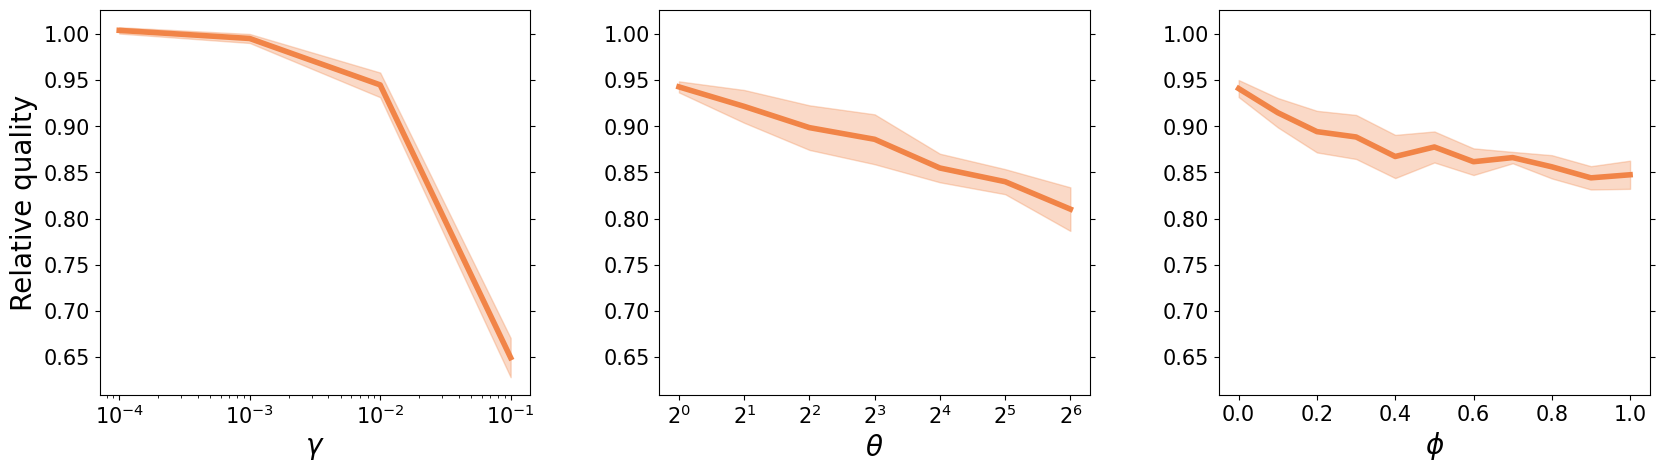

In [31]:
fpath = os.path.join(PLOT_DIR, "botparam")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    1, 3, figsize=(20, 5), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use("stylesheet.mplstyle")


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# # THETA
ax = axs[1]
draw_lines(ax, thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)
# ax.xaxis.set_major_locator(plt.MultipleLocator())

# PHI
ax = axs[2]
draw_lines(ax, phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None
)

if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

# Contour plots
First we need to convert data to the right input shape for matplotlib plot_surface()

### Data: Thetaphi matrix

In [32]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix = "relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=['theta','phi'], keep='first')
thetaphi = thetaphi.pivot(index='theta', columns='phi', values='mean_relative_quality').reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ['theta']+PHI
thetaphi.head()

values [0.8353027791215197, 0.8268985708664852, 0.8751353433124922, 0.8469556798067276, 0.8302467709907443]
values [0.7319573762048007, 0.7213159589761348, 0.7152814131569107, 0.731786083304182, 0.7318715074767025]
values [0.7330982048196079, 0.7064706361937353, 0.7199506949303267, 0.7292879587213186, 0.7029314355610189]
values [0.8661947699654342, 0.8394759538173387, 0.8069791423590347, 0.8633888864887671, 0.8344785494723246]
values [0.7944156437540136, 0.8063544866650713, 0.8098366243042032, 0.814647206437459, 0.8051738006155321]
values [0.7922058669708397, 0.7914321825914339, 0.7852273098620248, 0.7946893511049702, 0.8573025518412062]
values [0.7228749545636164, 0.7293193080674902, 0.742610123808348, 0.7355752196635992, 0.7372531175553261]
values [0.6996542436042014, 0.7132754269351785, 0.7218931175833665, 0.7064850312242347, 0.7049704529216138]
values [0.7571299305617266, 0.7637990067917599, 0.7464984904247298, 0.7769844783879587, 0.7201701677144595]
values [0.7674682966349108, 0.7

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.942628,0.909067,0.897508,0.895517,0.878678,0.861603,0.867243,0.849867,0.846007,0.844396,0.856066
1,2,0.921505,0.887572,0.868192,0.854360,0.842908,0.824900,0.829298,0.839524,0.821557,0.815855,0.831059
2,4,0.898503,0.842103,0.833465,0.827381,0.808825,0.814247,0.809805,0.794755,0.790547,0.790134,0.781421
3,8,0.885867,0.826799,0.806086,0.808921,0.791737,0.779846,0.759322,0.760806,0.765059,0.755417,0.757544
4,16,0.854768,0.823073,0.794270,0.773681,0.773789,0.758306,0.755996,0.740019,0.752916,0.744605,0.738152


In [33]:
tp_matrix = thetaphi.loc[:,PHI].values
#Check shape:
tp_matrix.shape 

(7, 11)

### Data: Thetagamma matrix

In [34]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix = "relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=['theta','gamma'], keep='first')
thetagamma = thetagamma.pivot(index='theta', columns='gamma', values='mean_relative_quality').reset_index()
thetagamma.head()

values [0.9946309395348295, 0.9891904335662357, 0.9984958038658606, 0.9956644918796216, 0.9873362995444378]
values [0.8924887943346486, 0.8983602362494326, 0.8743305124154249, 0.9116323340461783, 0.8901087510278857]
values [0.9397905853490436, 0.9695990843649674, 0.9983788569686947, 0.9809255151192412, 0.9796261021543893]
values [0.5284182979530917, 0.5209451799790755, 0.52780255584434, 0.5139201534035482, 0.5200562649064905]
values [0.9801206800445319, 0.9831912723341861, 0.9576096324936902, 0.9760046280675566, 0.984602265722163]
values [0.9999003972298011, 0.9996008585016394, 1.002508668004614, 0.9950517573767369, 1.0015732064054848]
values [0.9980231180110684, 1.0008334214171342, 0.9924066091889009, 0.9975853247741119, 0.9982229813696956]
values [0.9914929914516563, 0.9934662534126947, 0.9993415847770489, 1.0008047847054844, 0.9944583476748334]
values [0.9890278299665721, 1.0067404151362738, 1.0000045239070048, 1.007053159281678, 1.0028421609813027]
values [0.9804938452248525, 0.993

gamma,theta,0.0001,0.001,0.01,0.1
0,1,1.003840,0.995058,0.944784,0.649404
1,2,1.001298,0.991176,0.928727,0.612885
2,4,0.999697,0.993064,0.892989,0.573212
3,8,0.999727,0.988752,0.893384,0.552273
4,16,1.001134,0.976306,0.860792,0.522228


In [35]:
tg_matrix = thetagamma.loc[:,GAMMA].values
tg_matrix.shape

(7, 4)

### Data: Phigamma matrix

In [36]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix = "relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=['phi','gamma'], keep='first')
phigamma = phigamma.pivot(index='phi', columns='gamma', values='mean_relative_quality').reset_index()
phigamma.head()

values [0.9827144323504275, 0.9942150582178814, 0.9808647422436381, 0.9904498260844032, 0.9860287379879428]
values [0.8807813182017218, 0.9195550088323835, 0.8544583237157238, 0.8981039625950621, 0.8890362748662108]
values [0.9662163925012105, 0.9472003147478567, 0.966075390467417, 0.9852068713845701, 0.9928818703379416]
values [0.9947335598238182, 1.0027206786680989, 1.0074151169802408, 0.9935468713409692, 0.9965980374447818]
values [0.9654815441146132, 0.9609281911736468, 0.9756862003239986, 0.9845721784760026, 0.9821364718036354]
values [0.561390129788322, 0.5902489546645344, 0.5950498334963651, 0.5717521023543322, 0.5758578513317596]
values [0.9533241810193509, 0.9947833285635048, 0.9856999999840355, 0.9636194299056439, 0.9896914917959847]
values [0.8701842268187292, 0.8723249140038403, 0.8565389646136542, 0.8640386416233601, 0.8671607638727707]
values [0.998402131181964, 0.9997859095309868, 0.990527125836505, 0.9923302666765677, 1.0005901643488035]
values [0.9641587420053898, 0.97

gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,1.001977,0.996213,0.940808,0.660727
1,0.1,0.997663,0.989113,0.914661,0.607765
2,0.2,1.000280,0.986855,0.894152,0.599733
3,0.3,0.996327,0.976086,0.888387,0.582182
4,0.4,0.994032,0.977424,0.867236,0.578860


In [37]:
pg_matrix = phigamma.loc[:,GAMMA].values
pg_matrix.shape

(11, 4)

### Plot

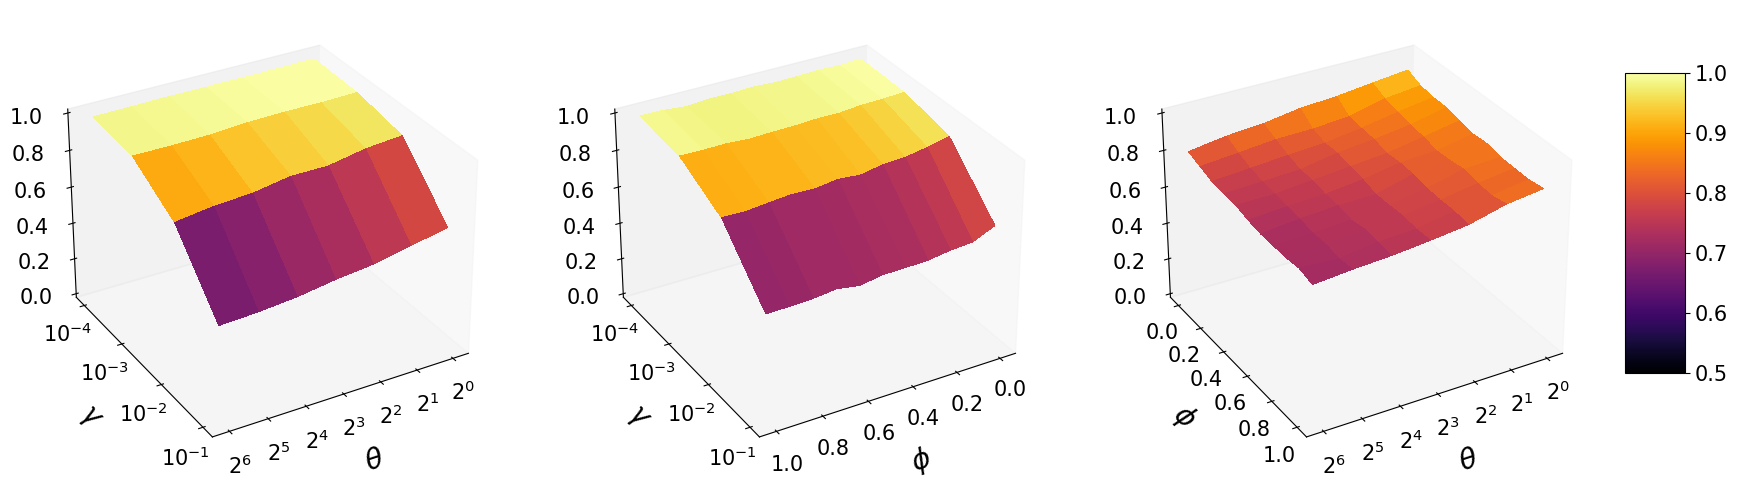

In [38]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet 
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238

def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$" 
  
fpath = os.path.join(PLOT_DIR, "joint")  
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1,3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN=np.round(min_qual,2)
VMAX=np.round(max_qual,2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA              
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax=axs[0]
surf = ax.plot_surface(np.log2(X), np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val,pos: log_tick_formatter(val,base=10)))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis='y', nbins=len(GAMMA)) #Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


# ## PHIGAMMA              
ax=axs[1]

X=PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX
                          )

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val,pos: log_tick_formatter(val,base=10)))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis='y', nbins=len(GAMMA)) # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, .27, .03, .5])# x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, 
             cax=cbar_ax
            )


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax=axs[2]
surf = ax.plot_surface(np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0,1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Bot targeting

Differences in overall quality are insignificant for $\gamma=0.01$. Were plotting different bot targeting strategies for $\gamma=0.1$

In [39]:
data = read_data(RES_DIR, folders=["strategies_5runs"])
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. hubs: Welch's t-test independent samples, P_val:9.733e-03 t=-3.428e+00
random vs. misinformation: Welch's t-test independent samples, P_val:2.144e-02 t=-2.935e+00
random vs. liberal: Welch's t-test independent samples, P_val:1.792e-05 t=-1.110e+01
random vs. conservative: Welch's t-test independent samples, P_val:7.376e-05 t=-7.446e+00


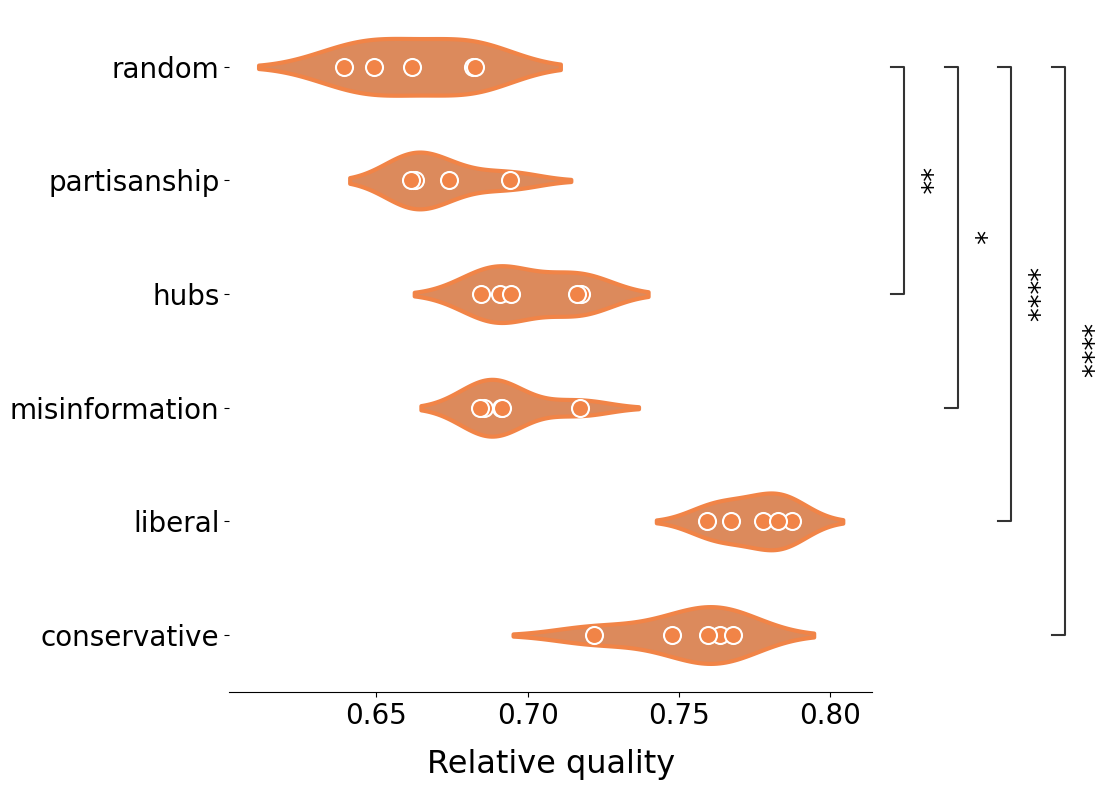

In [40]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    #         ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()